<a href="https://www.kaggle.com/code/sreejitamukherjee/mastercard-stock-data-forecasting?scriptVersionId=137323224" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_info.csv
/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv
/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
   
# For time stamps
from datetime import datetime
from math import sqrt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

In [3]:
data= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')
market_data=pd.read_csv('/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv')

In [4]:
data.head(1000)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0
...,...,...,...,...,...,...,...,...
995,2010-05-10,22.052394,22.253135,21.518967,21.705572,29826000,0.0,0.0
996,2010-05-11,21.432253,21.439794,20.850762,21.039251,29271000,0.0,0.0
997,2010-05-12,21.205125,22.262554,21.166484,21.923271,29123000,0.0,0.0
998,2010-05-13,21.930813,22.611262,21.729128,21.894058,22049000,0.0,0.0


In [5]:
data.describe(include='object').T

,count,unique,top,freq
Date,3872,3872,2006-05-25,1


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872 entries, 0 to 3871
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3872 non-null   object 
 1   Open          3872 non-null   float64
 2   High          3872 non-null   float64
 3   Low           3872 non-null   float64
 4   Close         3872 non-null   float64
 5   Volume        3872 non-null   int64  
 6   Dividends     3872 non-null   float64
 7   Stock Splits  3872 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 242.1+ KB


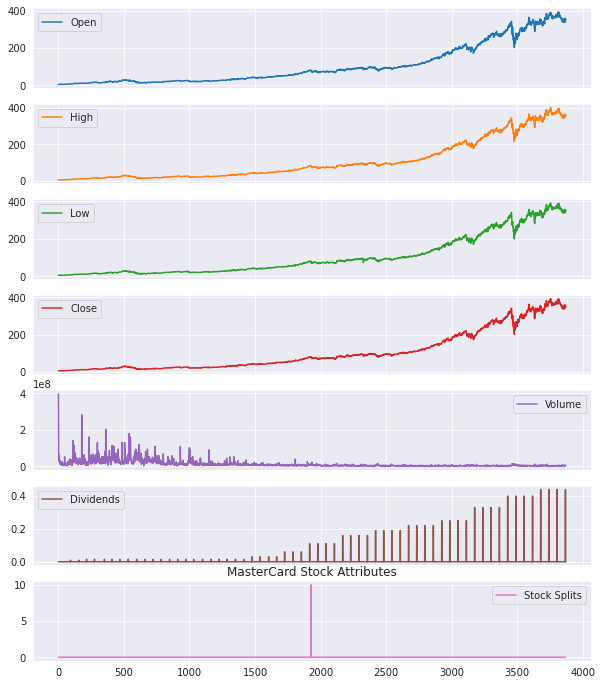

In [7]:
data.plot(subplots = True, figsize = (10,12))
plt.title('MasterCard Stock Attributes')
plt.show()

# ****Plot and Calculate Daily Returns

Value at risk testing

In [8]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', parse_dates=["Date"], index_col="Date")

# Calculate the daily returns as a percentage change
Returns = df["Close"].pct_change()
print(Returns)




Date
2006-05-25         NaN
2006-05-26   -0.023261
2006-05-30   -0.020699
2006-05-31    0.021363
2006-06-01    0.057187
                ...   
2021-10-05   -0.002876
2021-10-06    0.015967
2021-10-07    0.016253
2021-10-08    0.002967
2021-10-11   -0.022002
Name: Close, Length: 3872, dtype: float64


In [9]:
# Compute the 95% VaR using the historical method
var_99 = Returns.quantile(0.001)
print(var_99)

-0.10343960567306963


we are 99.9% confident that the stock will not lose more than 10% of its value in a single day

In [10]:
df["Returns"] = Returns

In [11]:
Returns.head(100)

Date
2006-05-25         NaN
2006-05-26   -0.023261
2006-05-30   -0.020699
2006-05-31    0.021363
2006-06-01    0.057187
                ...   
2006-10-10   -0.012225
2006-10-11   -0.033514
2006-10-12    0.013093
2006-10-13   -0.004545
2006-10-16    0.017264
Name: Close, Length: 100, dtype: float64

In [12]:
Returns.dropna()

Date
2006-05-26   -0.023261
2006-05-30   -0.020699
2006-05-31    0.021363
2006-06-01    0.057187
2006-06-02   -0.010945
                ...   
2021-10-05   -0.002876
2021-10-06    0.015967
2021-10-07    0.016253
2021-10-08    0.002967
2021-10-11   -0.022002
Name: Close, Length: 3871, dtype: float64

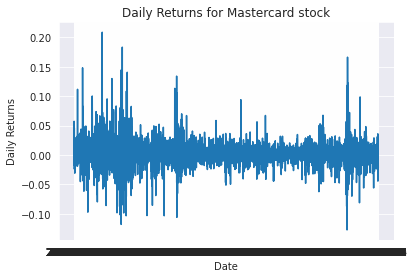

In [13]:
# Plot the daily returns
plt.plot(data['Date'], df['Returns'])
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.title('Daily Returns for Mastercard stock')
plt.show()



In [14]:
# Calculate some summary statistics of the daily returns
mean_return = df['Returns'].mean()
std_return = df['Returns'].std()
max_return = df['Returns'].max()
min_return = df['Returns'].min()

print(f"Mean daily return: {mean_return:.4f}")
print(f"Standard deviation of daily returns: {std_return:.4f}")
print(f"Maximum daily return: {max_return:.4f}")
print(f"Minimum daily return: {min_return:.4f}")

Mean daily return: 0.0014
Standard deviation of daily returns: 0.0217
Maximum daily return: 0.2085
Minimum daily return: -0.1273


In [15]:
df['Returns'].describe()

count    3871.000000
mean        0.001370
std         0.021701
min        -0.127255
25%        -0.008186
50%         0.001333
75%         0.010246
max         0.208463
Name: Returns, dtype: float64

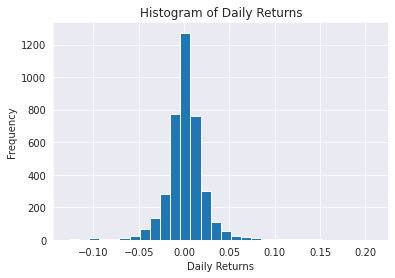

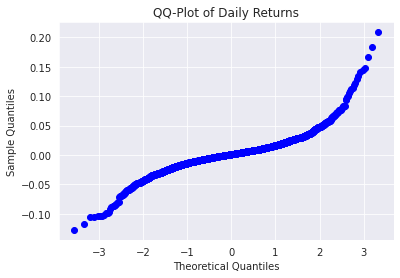

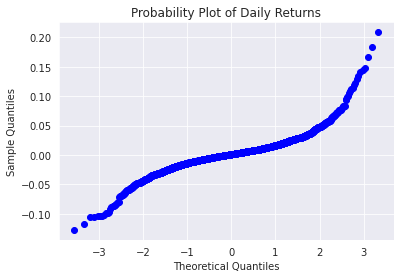

Skewness: nan
Kurtosis: nan


In [16]:
# Calculate skewness and kurtosis
skewness = stats.skew(Returns)
kurtosis = stats.kurtosis(Returns)

# Create histogram of daily returns
plt.hist(Returns, bins=30)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.show()

# Create QQ-plot of daily returns
stats.probplot(Returns, dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ-Plot of Daily Returns')
plt.show()

# Create probability plot of daily returns
stats.probplot(Returns, dist='norm', plot=plt, fit=True)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Probability Plot of Daily Returns')
plt.show()

# Print skewness and kurtosis
print('Skewness: {:.2f}'.format(skewness))
print('Kurtosis: {:.2f}'.format(kurtosis))

In [17]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', parse_dates=["Date"], index_col="Date")

# Calculate the daily returns as a percentage change
returns = df["Open"].pct_change()

# Compute the 95% VaR using the historical method
var_95 = returns.quantile(0.05)
print(var_95)

-0.030498458787065086


In [18]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', parse_dates=["Date"], index_col="Date")

# Calculate the daily returns as a percentage change
returns = df["High"].pct_change()

# Compute the 95% VaR using the historical method
var_95 = returns.quantile(0.05)
print(var_95)

-0.025279920772427522


In [19]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', parse_dates=["Date"], index_col="Date")

# Calculate the daily returns as a percentage change
returns = df["Low"].pct_change()

# Compute the 95% VaR using the historical method
var_95 = returns.quantile(0.05)
print(var_95)

-0.028914863554018733


The VAR Test at 95% confidence is more or less stable across open,close,high and low columns 

In [20]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', parse_dates=["Date"], index_col="Date")

# Calculate the daily returns as a percentage change
returns = df["Close"].pct_change()

# Compute the 99% VaR using the historical method
var_99 = returns.quantile(0.01)
print(var_99)

-0.05825236010110395


In [21]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', parse_dates=["Date"], index_col="Date")

# Calculate the daily returns as a percentage change
returns = df["Open"].pct_change()

# Compute the 99% VaR using the historical method
var_99 = returns.quantile(0.01)
print(var_99)

-0.06285875339718852


In [22]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


In [23]:
df1=df.drop('Dividends',axis=1)
df2=df1.drop('Stock Splits',axis=1)

In [24]:
# Perform Shapiro-Wilk normality test
shapiro_test = stats.shapiro(Returns)
shapiro_statistic, shapiro_p_value = shapiro_test
print('Shapiro-Wilk Test')
print('Statistic:', shapiro_statistic)
print('p-value:', shapiro_p_value)

# Perform Anderson-Darling normality test
anderson_test = stats.anderson(Returns, dist='norm')
anderson_statistic, anderson_critical_values, anderson_significance_levels = anderson_test
print('\nAnderson-Darling Test')
print('Statistic:', anderson_statistic)
print('Critical Values:', anderson_critical_values)
print('Significance Levels:', anderson_significance_levels)

Shapiro-Wilk Test
Statistic: nan
p-value: 1.0

Anderson-Darling Test
Statistic: nan
Critical Values: [0.575 0.655 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]


In [25]:
import numpy as np
from scipy.stats import chisquare

# Define the null hypothesis
null_hypothesis = "Returns follow a uniform distribution"

# Define the expected distribution
expected_distribution = np.repeat(1/len(Returns), len(Returns))

# Perform the chi-squared goodness-of-fit test
test_stat, p_value = chisquare(f_obs=Returns, f_exp=expected_distribution)

# Print the test results
print("Null Hypothesis: ", null_hypothesis)
print("Expected Distribution: Uniform")
print("Chi-squared Test Statistic: ", test_stat)
print("p-value: ", p_value)


Null Hypothesis:  Returns follow a uniform distribution
Expected Distribution: Uniform
Chi-squared Test Statistic:  nan
p-value:  nan


In [26]:
# Calculate daily returns
returns = df2.pct_change().dropna()

# Print the first few rows of the returns data
print(returns.head(100))

                Open      High       Low     Close    Volume
Date                                                        
2006-05-26  0.148884  0.014984  0.097264 -0.023261 -0.739355
2006-05-30 -0.028726 -0.037655 -0.028565 -0.020699 -0.515760
2006-05-31 -0.013787  0.008448  0.035006  0.021363 -0.398733
2006-06-01  0.013078  0.060406  0.012401  0.057187  1.077995
2006-06-02  0.079457  0.012474  0.042093 -0.010945 -0.402461
...              ...       ...       ...       ...       ...
2006-10-11 -0.002811 -0.030716 -0.031489 -0.033514  0.325773
2006-10-12 -0.026075 -0.002535  0.006444  0.013093 -0.573965
2006-10-13  0.027496  0.012426  0.016007 -0.004545 -0.251108
2006-10-16 -0.014084  0.000139  0.000430  0.017264 -0.222507
2006-10-17  0.015715 -0.007112 -0.008303 -0.025245  0.120768

[100 rows x 5 columns]


In [27]:
# Drop date column
data_numeric = data.drop('Date', axis=1)

# Check for stationarity
def adfuller_test(series, signif=0.05):
    adf_test = sm.tsa.stattools.adfuller(series, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    if adf_output['p-value'] <= signif:
        print(f"ADF test indicates that the series {series.name} is stationary.")
    else:
        print(f"ADF test indicates that the series {series.name} is non-stationary.")
    return adf_output

# Apply adfuller_test function to each column
for col in data_numeric.columns:
    adfuller_test(data_numeric[col])


ADF test indicates that the series Open is non-stationary.
ADF test indicates that the series High is non-stationary.
ADF test indicates that the series Low is non-stationary.
ADF test indicates that the series Close is non-stationary.
ADF test indicates that the series Volume is stationary.
ADF test indicates that the series Dividends is stationary.
ADF test indicates that the series Stock Splits is stationary.


In [28]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(data.Close.dropna())
print(result[0])
print(result[1])

1.2039258297952187
0.9960128949994066


In [29]:
import scipy.stats as stats

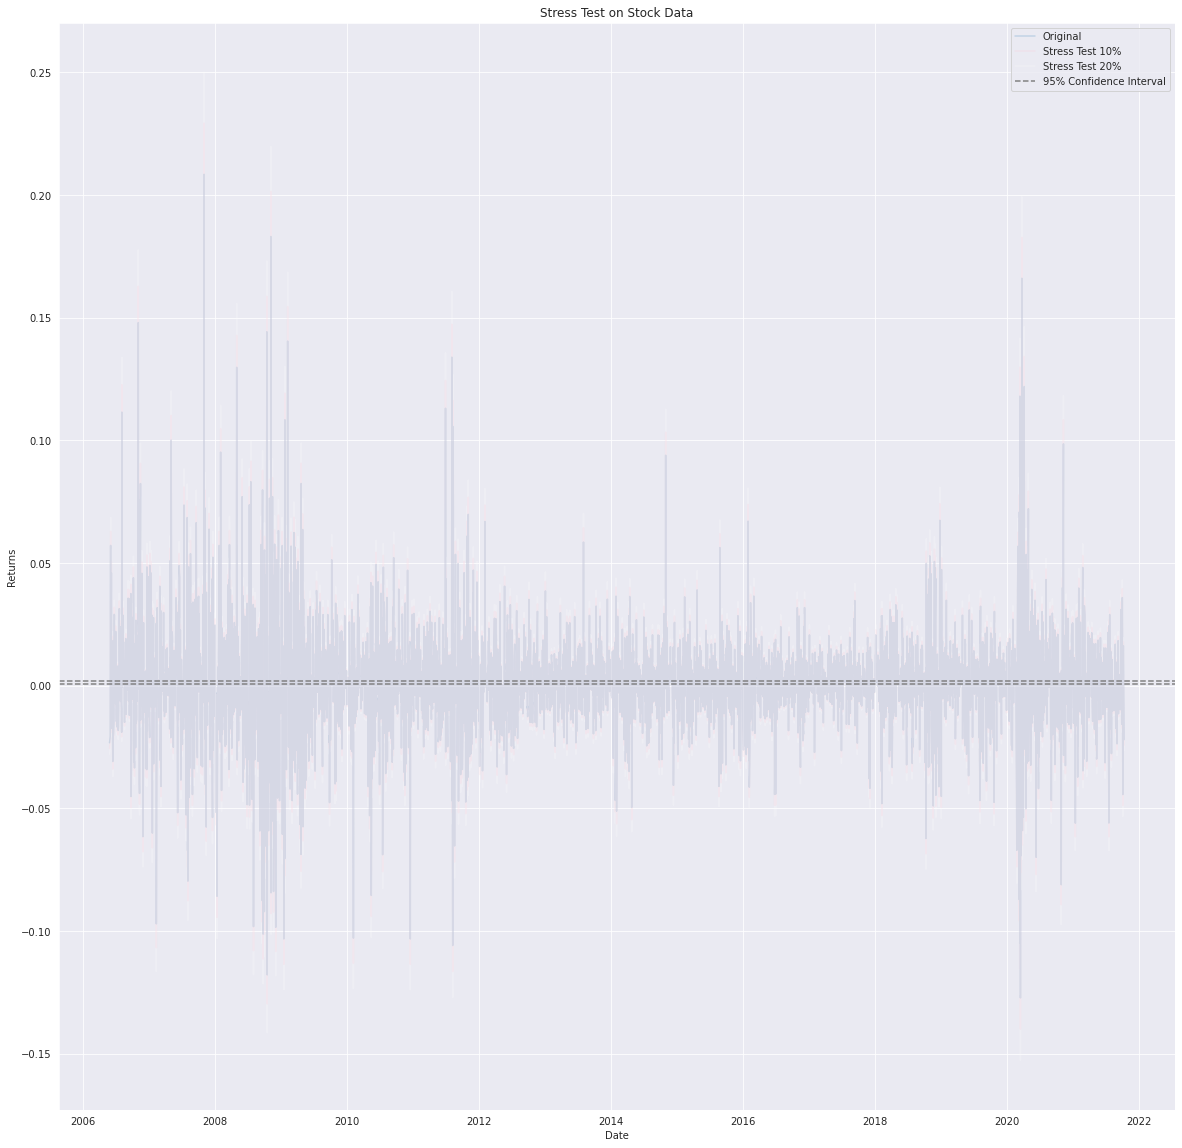

In [30]:
# Calculate daily returns
df['Returns'] = df['Close'].pct_change()

# Calculate volatility
df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(252)

# Define stress test function
def stress_test(df, pct_change):
    """
    Simulate a stress test on the stock data by applying a percentage change to the returns.
    """
    df_stress = df.copy()
    df_stress['Returns'] = df_stress['Returns'] * (1 + pct_change)
    df_stress['Close'] = df_stress['Close'].shift(1) * (1 + df_stress['Returns'])
    return df_stress

# Define confidence interval function
def calculate_confidence_interval(df, alpha=0.05):
    """
    Calculate the confidence interval for the stock returns based on the given alpha level.
    """
    n = len(df)
    mean_return = df['Returns'].mean()
    std_error = df['Returns'].std() / np.sqrt(n)
    t_value = abs(stats.t.ppf(alpha/2, n-1))
    lower_bound = mean_return - t_value * std_error
    upper_bound = mean_return + t_value * std_error
    return (lower_bound, upper_bound)

# Run stress tests and calculate confidence intervals
df_10 = stress_test(df, 0.1)
df_20 = stress_test(df, 0.2)
conf_interval = calculate_confidence_interval(df)

# Plot results
plt.figure(figsize=(20, 20))
plt.plot(df['Returns'], label='Original',alpha=0.2)
plt.plot(df_10['Returns'], label='Stress Test 10%',color='pink',alpha=0.2)
plt.plot(df_20['Returns'], label='Stress Test 20%',color='white',alpha=0.2)
plt.axhline(y=conf_interval[0], linestyle='--', color='gray', label='95% Confidence Interval')
plt.axhline(y=conf_interval[1], linestyle='--', color='gray')
plt.legend()
plt.title('Stress Test on Stock Data')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

Epoch 1/10
193/193 [==============================] - 7s 17ms/step - loss: 0.0012
Epoch 2/10
193/193 [==============================] - 3s 18ms/step - loss: 2.8218e-05
Epoch 3/10
193/193 [==============================] - 3s 18ms/step - loss: 3.1106e-05
Epoch 4/10
193/193 [==============================] - 4s 18ms/step - loss: 3.7469e-05
Epoch 5/10
193/193 [==============================] - 3s 18ms/step - loss: 2.8928e-05
Epoch 6/10
193/193 [==============================] - 3s 18ms/step - loss: 3.0270e-05
Epoch 7/10
193/193 [==============================] - 4s 19ms/step - loss: 3.0012e-05
Epoch 8/10
193/193 [==============================] - 3s 18ms/step - loss: 3.4037e-05
Epoch 9/10
193/193 [==============================] - 3s 17ms/step - loss: 2.9658e-05
Epoch 10/10
193/193 [==============================] - 3s 17ms/step - loss: 3.2000e-05


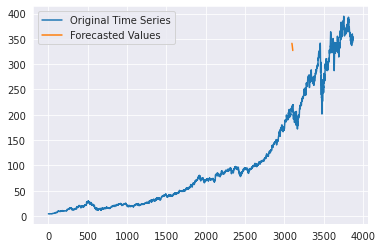

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the non-stationary time series data
data = data= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')
time_series = data['Close']  # Replace 'value_column' with the column name containing the time series values

## Normalize the time series data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_series = scaler.fit_transform(time_series.values.reshape(-1, 1))

# Prepare the training data
train_size = int(len(normalized_series) * 0.8)
train_data = normalized_series[:train_size]

# Create the training data with timesteps
timesteps = 12  # Number of timesteps to consider for each input
X_train, y_train = [], []
for i in range(timesteps, len(train_data)):
    X_train.append(train_data[i - timesteps:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the training data for input into the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Generate forecasts for the year 2023
future_period = 12  # Number of future periods to forecast
future_input = normalized_series[-timesteps:].reshape(1, -1, 1)
forecast = []
for i in range(future_period):
    predicted_value = model.predict(future_input)[0, 0]
    forecast.append(predicted_value)
    future_input = np.roll(future_input, -1)
    future_input[0, -1, 0] = predicted_value

# Inverse transform the forecasts to obtain the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot the original time series and the forecasted values
plt.plot(time_series.values, label='Original Time Series')
plt.plot(np.concatenate((np.full(train_size, np.nan), forecast.flatten())), label='Forecasted Values')
plt.legend()
plt.show()

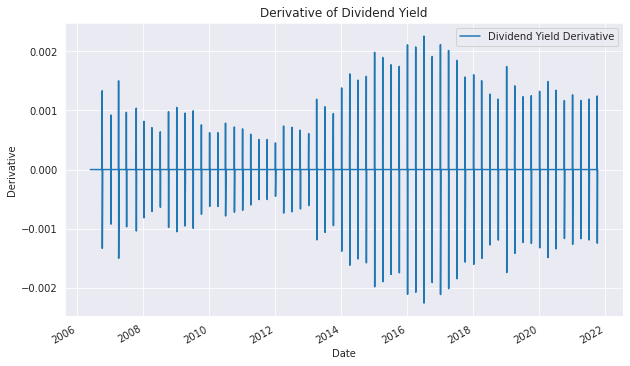

In [32]:
import pandas as pd
import numpy as np


# Calculate dividend yield
df['Dividend Yield'] = df['Dividends'] / df['Close']

# Calculate derivative of dividend yield
df['Dividend Yield Derivative'] = df['Dividend Yield'].diff()

# Plot results
df[['Dividend Yield Derivative']].plot(figsize=(10, 6))
plt.title('Derivative of Dividend Yield')
plt.xlabel('Date')
plt.ylabel('Derivative')
plt.show()


In [33]:
# Make data stationary
data_diff = data_numeric.diff().dropna()

# Check for stationarity again
for col in data_diff.columns:
    adfuller_test(data_diff[col])


ADF test indicates that the series Open is stationary.
ADF test indicates that the series High is stationary.
ADF test indicates that the series Low is stationary.
ADF test indicates that the series Close is stationary.
ADF test indicates that the series Volume is stationary.
ADF test indicates that the series Dividends is stationary.
ADF test indicates that the series Stock Splits is stationary.


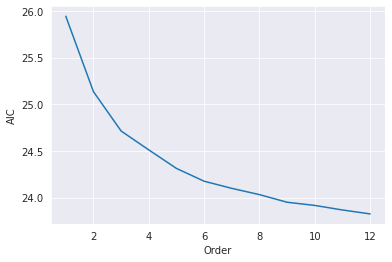

In [34]:
# Determine optimal lag order
model = VAR(data_diff)
aic_scores = []
for i in range(1, 13):
    result = model.fit(i)
    aic_scores.append(result.aic)
plt.plot(range(1, 13), aic_scores)
plt.xlabel('Order')
plt.ylabel('AIC')
plt.show()


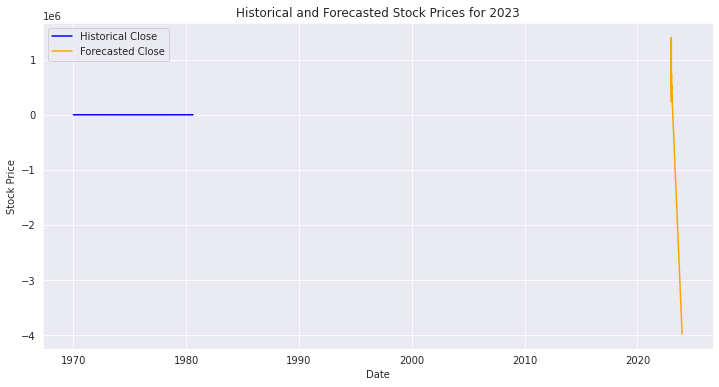

                Date        Open        High         Low         Close  \
2023-01-02 -7.062031  351.630977  348.184877  351.368552  6.914360e+05   
2023-01-03  0.379977  352.158003  349.140331  351.777146  1.403899e+06   
2023-01-04  0.360964  351.597626  349.131975  351.645127  6.141943e+05   
2023-01-05  0.636708  352.042922  349.954041  352.276589  2.413592e+05   
2023-01-06 -0.227302  352.392210  350.066694  352.553169  6.228433e+05   
...              ...         ...         ...         ...           ...   
2023-12-13  0.088809  374.209082  393.422237  396.060032 -3.905806e+06   
2023-12-14  0.088809  374.299200  393.600296  396.238781 -3.924325e+06   
2023-12-15  0.088809  374.389318  393.778355  396.417531 -3.942843e+06   
2023-12-18  0.088809  374.479436  393.956414  396.596280 -3.961362e+06   
2023-12-19  0.088809  374.569554  394.134472  396.775030 -3.979880e+06   

              Volume     Dividends  
2023-01-02  0.120258 -1.329982e-02  
2023-01-03  0.019988  9.999616e-03  


In [35]:
# Fit VAR model
model = VAR(data_diff)
results = model.fit(3)

# Make predictions for the year 2023
forecast_period = 252  # Number of business days in 2023 (assuming 252 trading days in a year)
forecast_input = data_diff.values[-3:]  # Using the last 3 observations as input for forecasting
fc = results.forecast(y=forecast_input, steps=forecast_period)
data_forecast = pd.DataFrame(fc, columns=data.columns[:7])

# Calculate forecasted stock values
data_forecast['Open'] = data_numeric['Open'].iloc[-1] + data_forecast['Open'].cumsum()
data_forecast['High'] = data_forecast['Open'] + data_forecast['High'].cumsum()
data_forecast['Low'] = data_forecast['Open'] + data_forecast['Low'].cumsum()
data_forecast['Close'] = data_forecast['Open'] + data_forecast['Close'].cumsum()

# Generate date index for 2023
start_date_2023 = pd.to_datetime('2023-01-01')  # You can adjust this start date accordingly
date_index_2023 = pd.date_range(start=start_date_2023, periods=forecast_period, freq='B')
data_forecast.index = date_index_2023

# Plot the forecasted stock prices
plt.figure(figsize=(12, 6))
plt.plot(data_numeric['Close'], label='Historical Close', color='blue')
plt.plot(data_forecast['Close'], label='Forecasted Close', color='orange')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical and Forecasted Stock Prices for 2023')
plt.legend()
plt.show()

# Print the forecasted values for the year 2023
print(data_forecast)